In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_pickle('E:/for_hypo.pkl')
df_norag = pd.read_pickle('E:/baseline.pkl')

In [78]:
df.to_csv('E:/for_hypo')

In [79]:
df_norag.to_csv('E:/baseline')

# RQ 3
Проверка влияние с и k1 на качество qa

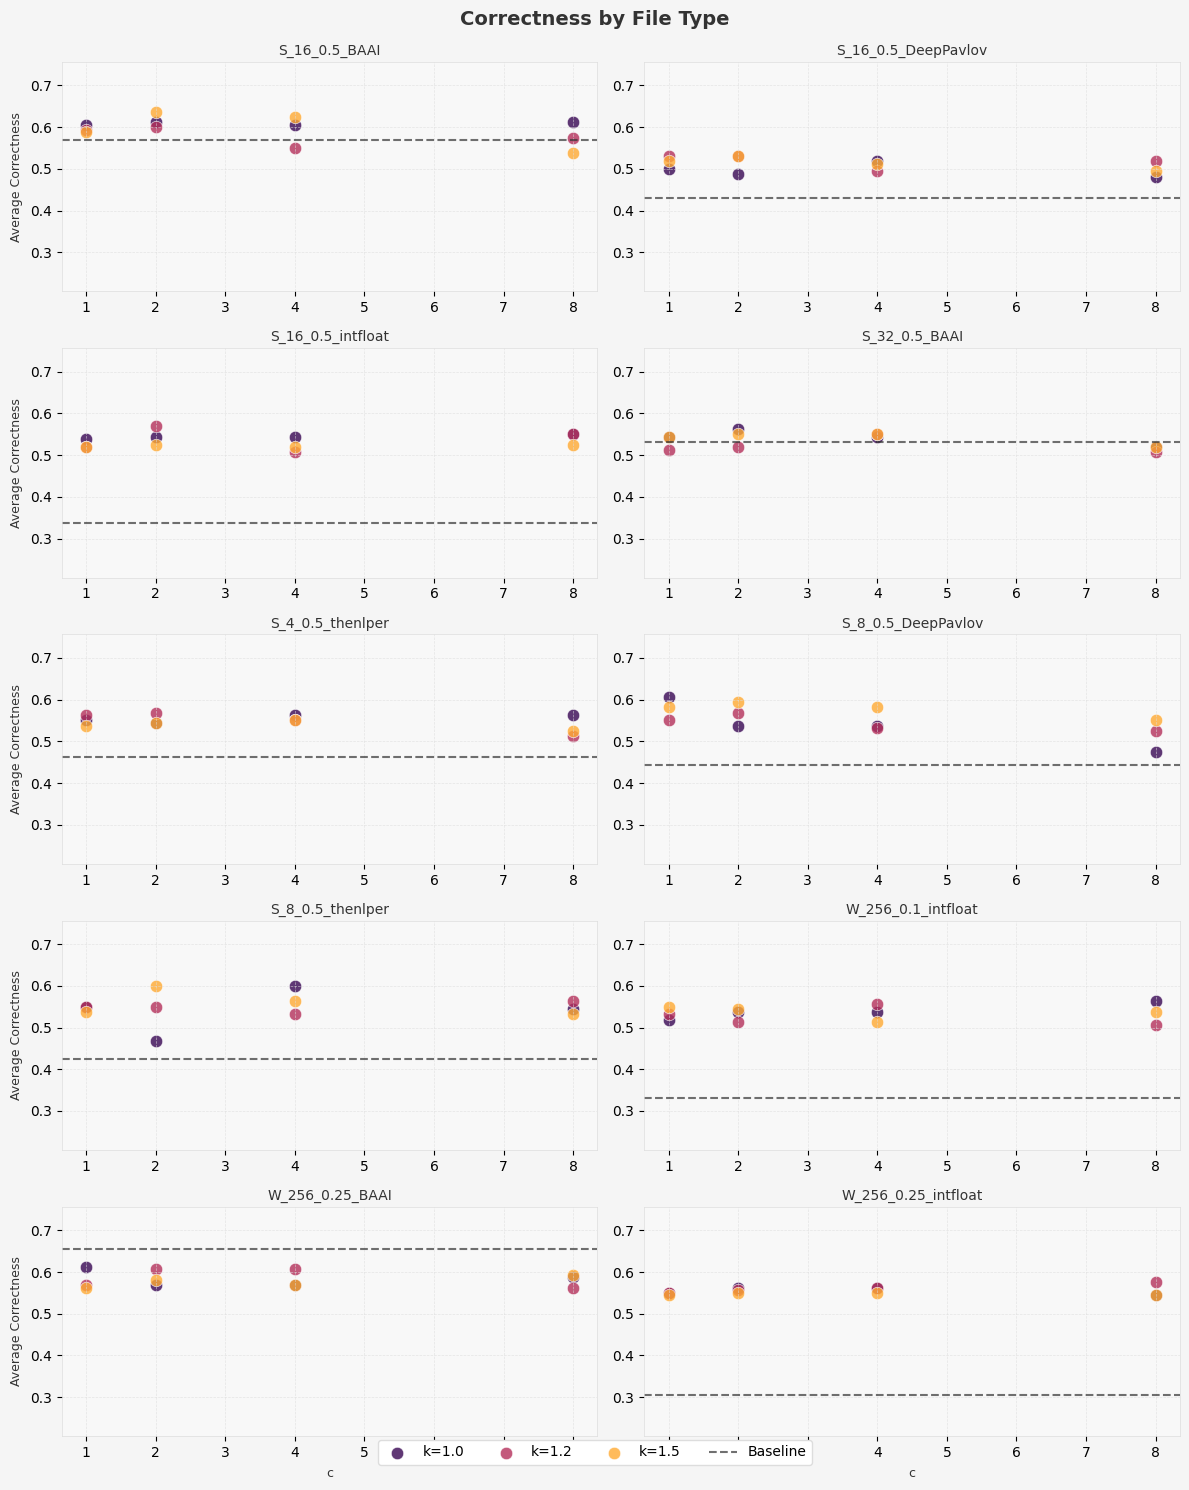

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Prepare data
models = list(set(df[(df.k1 != 1.2) & (df.c != 60)].file))
t = df[df.file.isin(models)]
df_grouped = t.groupby(['file', 'c', 'k1'])['correctness'].mean().reset_index() 
df_grouped['is_baseline'] = df_grouped.apply(lambda x: int(x['c']==60 and x['k1']==1.2), axis=1)

base = df_grouped[df_grouped.is_baseline==1]
not_base = df_grouped[df_grouped.is_baseline==0]

# Set up inferno color scheme
colors = [(0.001462, 0.000466, 0.013866),
          (0.218, 0.024, 0.324),
          (0.539, 0.071, 0.423),
          (0.865, 0.302, 0.296),
          (1.0, 0.667, 0.198),
          (0.988, 0.998, 0.645)]
cmap = LinearSegmentedColormap.from_list('inferno', colors)

# Create figure with 5x2 subplots
fig, axes = plt.subplots(5, 2, figsize=(12, 15), facecolor='#f5f5f5')
fig.subplots_adjust(hspace=0.4, wspace=0.2)
axes = axes.flatten()

# Get all files and sort them for consistent ordering
unique_files = sorted(df_grouped['file'].unique())

# Find global y limits for consistent scaling
y_min = df_grouped['correctness'].min() - 0.1
y_max = df_grouped['correctness'].max() + 0.1

# Color mapping for k1 values
k_values = [1.0, 1.2, 1.5]
k_colors = {1.0: cmap(0.2), 1.2: cmap(0.5), 1.5: cmap(0.8)}

# Plot each file in separate subplot
for i, file in enumerate(unique_files):
    ax = axes[i]
    ax.set_facecolor('#f8f8f8')
    
    # Plot baseline as horizontal line
    file_base = base[base['file'] == file]
    if not file_base.empty:
        baseline_value = file_base['correctness'].values[0]
        ax.axhline(y=baseline_value, color='#333333', linestyle='--', linewidth=1.5, alpha=0.7)
    
    # Plot points for each k value
    for k in k_values:
        file_data = not_base[(not_base['file'] == file) & (not_base['k1'] == k)]
        if not file_data.empty:
            ax.scatter(file_data['c'], file_data['correctness'], 
                       color=k_colors[k], 
                       edgecolor='white',
                       linewidth=0.5,
                       s=80,
                       alpha=0.8,
                       label=f'k={k}')
    
    # Set subplot title and grid
    ax.set_title(file, fontsize=10, pad=5, color='#333333')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#dddddd')
    ax.set_ylim(y_min, y_max)
    
    # Only show x label on bottom row
    if i >= 8:
        ax.set_xlabel('c', fontsize=9, labelpad=5, color='#333333')
    
    # Only show y label on left column
    if i % 2 == 0:
        ax.set_ylabel('Average Correctness', fontsize=9, labelpad=5, color='#333333')
    
    # Add subtle border
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('#dddddd')
        spine.set_linewidth(0.5)

# Create a single legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
# Add baseline to legend if it exists
if not base.empty:
    handles.append(plt.Line2D([0], [0], color='#333333', linestyle='--', linewidth=1.5, alpha=0.7))
    labels.append('Baseline')

fig.legend(handles, labels, 
           frameon=True, framealpha=1, 
           facecolor='white', edgecolor='#dddddd',
           fontsize=10, bbox_to_anchor=(0.5, 0.02), 
           loc='lower center', borderaxespad=0., ncol=4)

# Add overall title
fig.suptitle('Correctness by File Type', fontsize=14, y=0.99, fontweight='bold', color='#333333')

plt.tight_layout()
plt.show()

# RQ 0
Влияник RAG на qa

In [4]:
not_base = df[df.dataset=='bench'].groupby(['file', 'k1', 'c'])['correctness'].sum().reset_index()

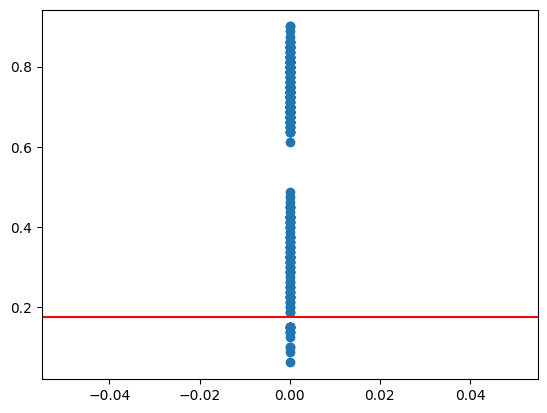

In [5]:
plt.scatter( [0 for i in range(240)], not_base.correctness/80)
plt.axhline(y=df_norag[df_norag.dataset=='bench'].correctness.sum() / 80, color='r', linestyle='-')

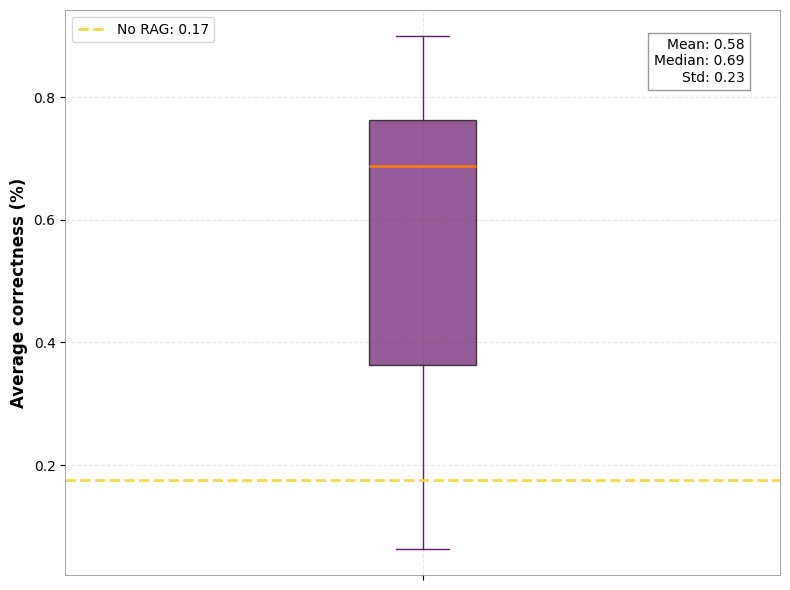

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# Set font to Times New Roman
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']

# Set style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Create figure
fig, ax = plt.subplots(figsize=(8, 6))

# Get inferno colormap
cmap = plt.get_cmap('inferno')
box_color = cmap(0.3)
median_color = cmap(0.7)
mean_line_color = cmap(0.9)

# Calculate statistics
data = not_base.correctness/80
mean_val = np.mean(data)
median_val = np.median(data)
std_val = np.std(data)

# Create boxplot
box = ax.boxplot(data, 
                 patch_artist=True,
                 boxprops=dict(facecolor=box_color, alpha=0.7),
                 medianprops=dict(color=median_color, linewidth=2),
                 whiskerprops=dict(color=box_color),
                 capprops=dict(color=box_color),
                 flierprops=dict(marker='o', markersize=5, 
                                 markerfacecolor=box_color, alpha=0.5))

# Add reference line
ref_value = df_norag[df_norag.dataset=='bench'].correctness.sum() / 80
ax.axhline(y=ref_value, color=mean_line_color, linestyle='--', linewidth=2, 
           label=f'No RAG: {ref_value:.2f}')

# Add statistics text
stats_text = f'Mean: {mean_val:.2f}\nMedian: {median_val:.2f}\nStd: {std_val:.2f}'
ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

# Customize plot
ax.set_ylabel('Average correctness (%)', fontsize=12, fontweight='bold')
ax.set_xticklabels([''], fontsize=12)
ax.set_title('', fontsize=14, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(fontsize=10)

# Adjust spines
for spine in ax.spines.values():
    spine.set_edgecolor('gray')
    spine.set_linewidth(0.5)

plt.tight_layout()
plt.show()

# RQ1

RMSE сигмоиды: 0.1416


C:\Users\evgen\AppData\Local\Temp\ipykernel_1992\404671680.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = t.groupby('relevance_bin').agg(


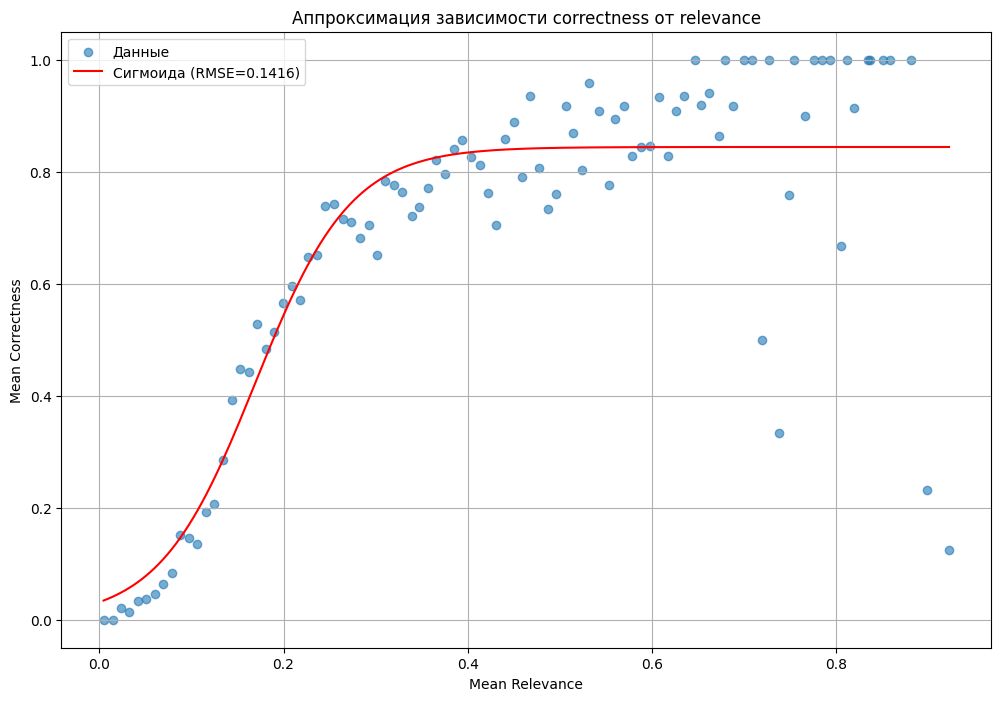

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# Предположим, у нас уже есть DataFrame df
# df = pd.read_csv('your_data.csv')  # если данные в файле

# 1. Разбиваем mean_relevance на 100 равных частей (бинов)
df['relevance_bin'] = pd.cut(df['mean_relevance'], bins=100)
t = df[df.dataset=='bench']
# 2. Группируем по бинам и считаем средний correctness
bin_stats = t.groupby('relevance_bin').agg(
    mean_relevance=('mean_relevance', 'mean'),
    mean_correctness=('correctness', 'mean')
).reset_index(drop=True)

# Удаляем строки с NaN (если такие есть)
bin_stats = bin_stats.dropna()

# 3. Определяем функции для аппроксимации
def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x - b)))

def log_func(x, a, b):
    return a * np.log(x + b)

def tanh_func(x, a, b):
    return a * np.tanh(b * x)

def sqrt_func(x, a, b):
    return a * np.sqrt(x) + b

# 4. Аппроксимируем данные
x = bin_stats['mean_relevance'].values
y = bin_stats['mean_correctness'].values

# Сигмоида
popt_sigmoid, _ = curve_fit(sigmoid, x, y, p0=[10, 0.5, 1], maxfev=10000)
y_sigmoid = sigmoid(x, *popt_sigmoid)

# Логарифм
popt_log, _ = curve_fit(log_func, x, y, p0=[1, 0.1], maxfev=10000)
y_log = log_func(x, *popt_log)

# Гиперболический тангенс
popt_tanh, _ = curve_fit(tanh_func, x, y, p0=[1, 1], maxfev=10000)
y_tanh = tanh_func(x, *popt_tanh)

# Квадратный корень
popt_sqrt, _ = curve_fit(sqrt_func, x, y, p0=[1, 0], maxfev=10000)
y_sqrt = sqrt_func(x, *popt_sqrt)

# Полиномиальная регрессия (степень 3)
poly_model = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),
    ('linear', LinearRegression())
])
poly_model.fit(x.reshape(-1, 1), y)
y_poly = poly_model.predict(x.reshape(-1, 1))

# 5. Вычисляем RMSE для каждой модели
rmse_sigmoid = np.sqrt(mean_squared_error(y, y_sigmoid))
rmse_log = np.sqrt(mean_squared_error(y, y_log))
rmse_tanh = np.sqrt(mean_squared_error(y, y_tanh))
rmse_sqrt = np.sqrt(mean_squared_error(y, y_sqrt))
rmse_poly = np.sqrt(mean_squared_error(y, y_poly))

print(f"RMSE сигмоиды: {rmse_sigmoid:.4f}")
# print(f"RMSE логарифма: {rmse_log:.4f}")
# print(f"RMSE tanh: {rmse_tanh:.4f}")
# print(f"RMSE корня: {rmse_sqrt:.4f}")
# print(f"RMSE полинома: {rmse_poly:.4f}")

# 6. Строим график
plt.figure(figsize=(12, 8))
plt.scatter(x, y, label='Данные', alpha=0.6)

x_smooth = np.linspace(x.min(), x.max(), 200)
plt.plot(x_smooth, sigmoid(x_smooth, *popt_sigmoid), 'r-', label=f'Сигмоида (RMSE={rmse_sigmoid:.4f})')
# plt.plot(x_smooth, log_func(x_smooth, *popt_log), 'g-', label=f'Логарифм (RMSE={rmse_log:.4f})')
# plt.plot(x_smooth, tanh_func(x_smooth, *popt_tanh), 'b-', label=f'Tanh (RMSE={rmse_tanh:.4f})')
# plt.plot(x_smooth, sqrt_func(x_smooth, *popt_sqrt), 'c-', label=f'Корень (RMSE={rmse_sqrt:.4f})')
# plt.plot(x_smooth, poly_model.predict(x_smooth.reshape(-1, 1)), 'm-', label=f'Полином (RMSE={rmse_poly:.4f})')

plt.xlabel('Mean Relevance')
plt.ylabel('Mean Correctness')
plt.title('Аппроксимация зависимости correctness от relevance')
plt.legend()
plt.grid(True)
plt.show()

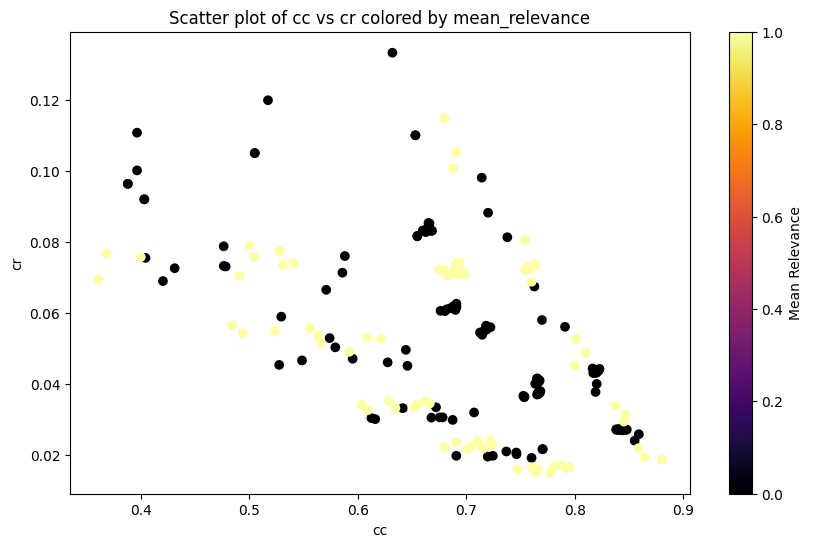

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

df['relevance_bin'] = pd.cut(df['mean_relevance'], bins=3)
df['relevance_bin_float'] = df.relevance_bin.apply(lambda x: x.left)

gdf = df.groupby(['chunk_strategy', 'chunk_len', 'stride', 'embedder', 'c',  'k1'])[['mean_relevance', 'cc', 'cr', 'correctness']].mean().reset_index()
gdf['chunk_strategy_label'] = gdf['chunk_strategy'].apply(lambda x: ['S', 'W'].index(x))
gdf['embedder_label'] = gdf['embedder'].apply(lambda x: ['BAAI', 'DeepPavlov', 'intfloat', 'thenlper'].index(x))

# Предполагаем, что df уже существует
plt.figure(figsize=(10, 6))
scatter = plt.scatter(gdf['cc'], gdf['cr'], c=gdf['chunk_strategy_label'], cmap='inferno')

plt.colorbar(scatter, label='Mean Relevance')
plt.xlabel('cc')
plt.ylabel('cr')
plt.title('Scatter plot of cc vs cr colored by mean_relevance')

plt.show()

C:\Users\evgen\AppData\Local\Temp\ipykernel_1992\122291412.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  inferno = get_cmap('inferno')


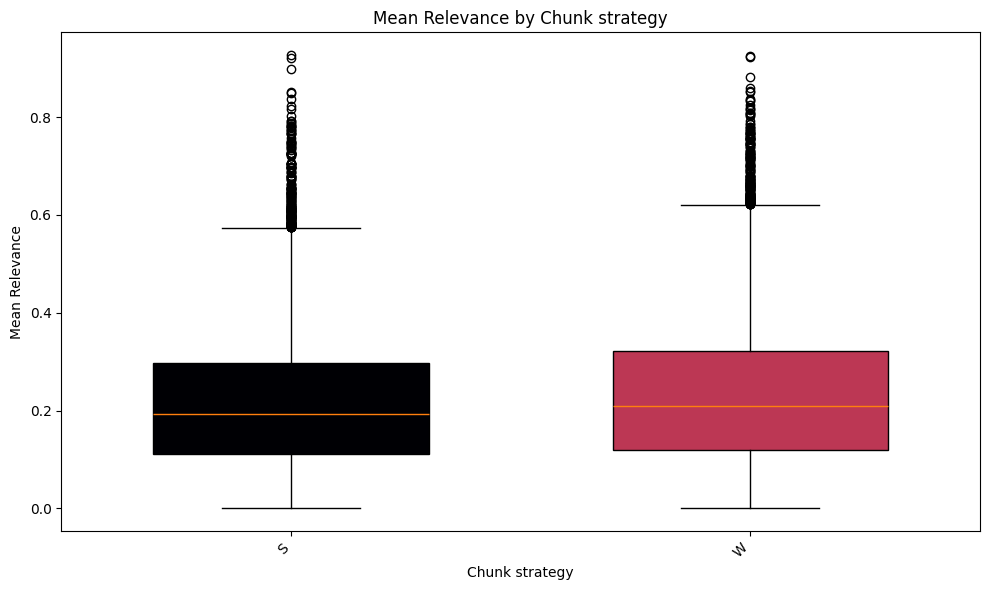

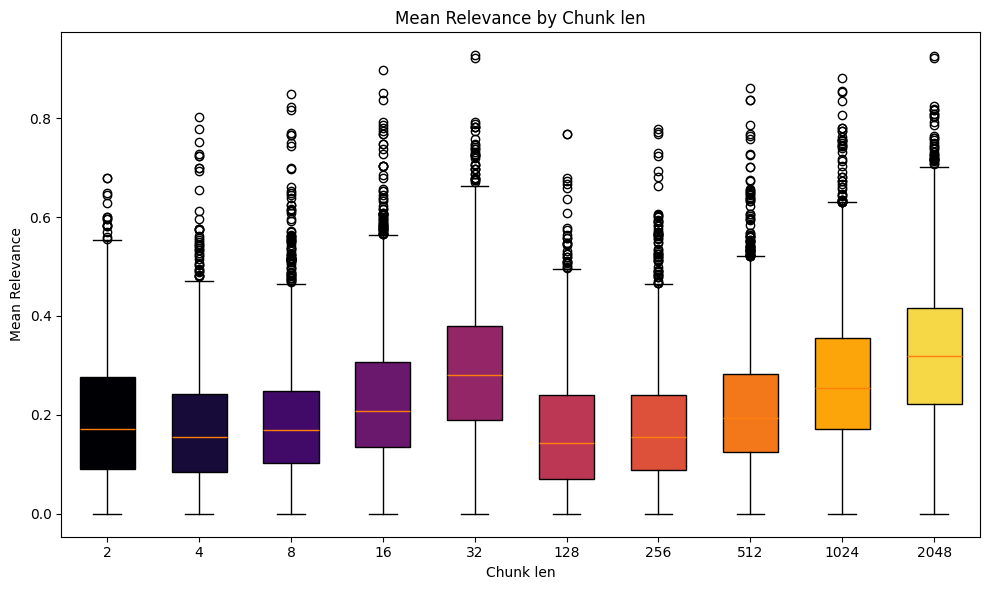

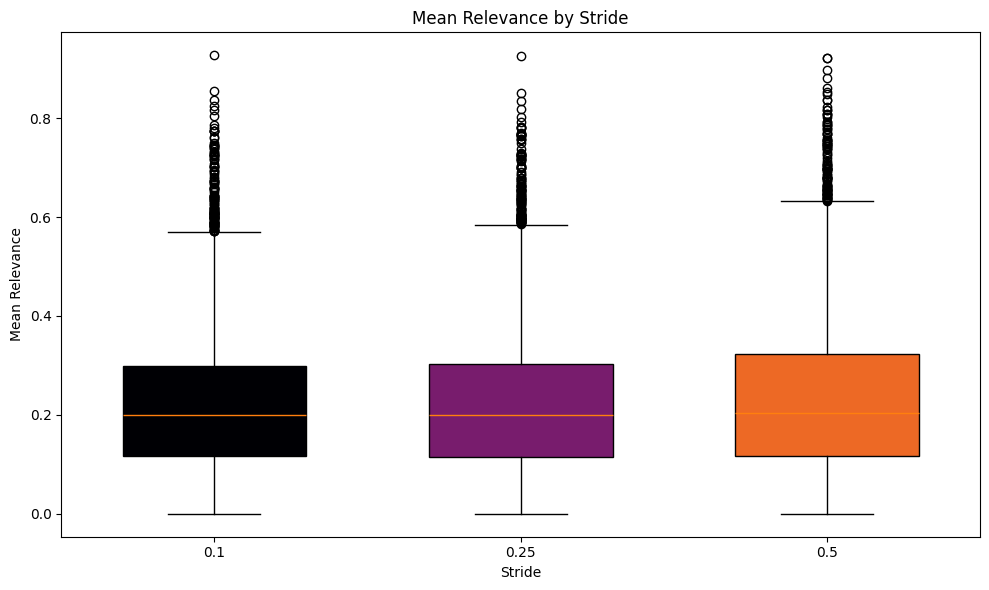

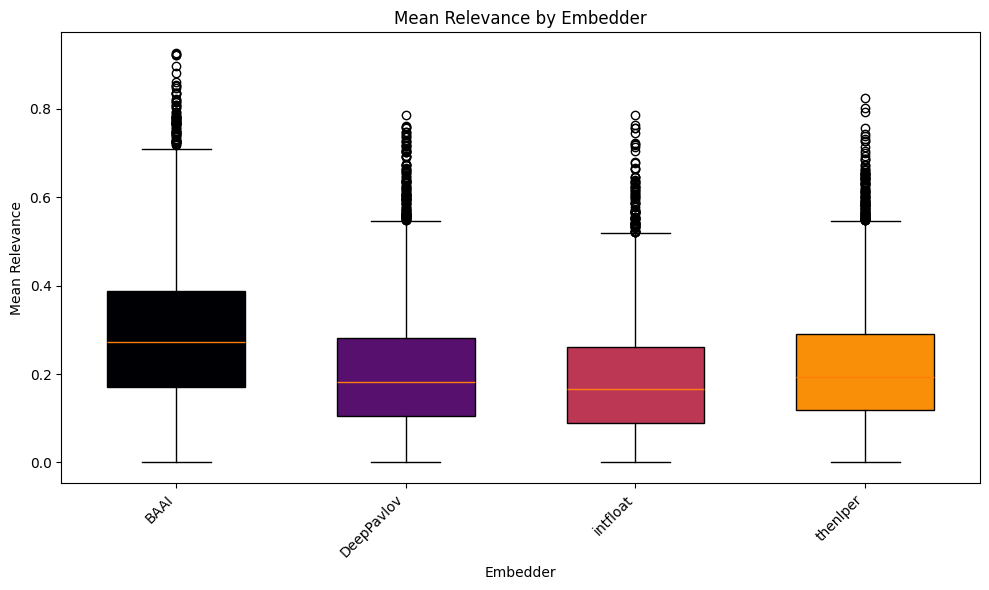

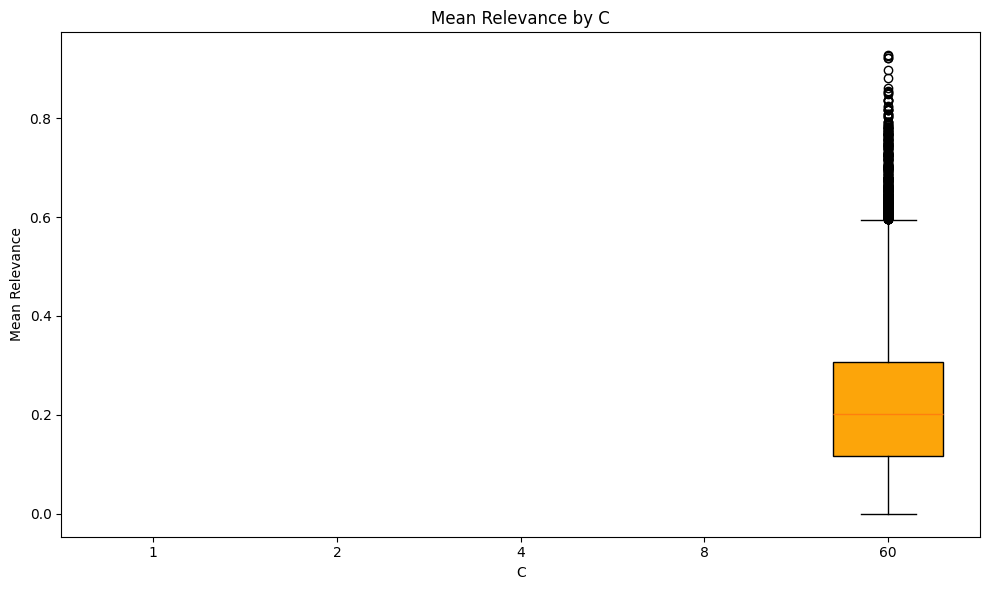

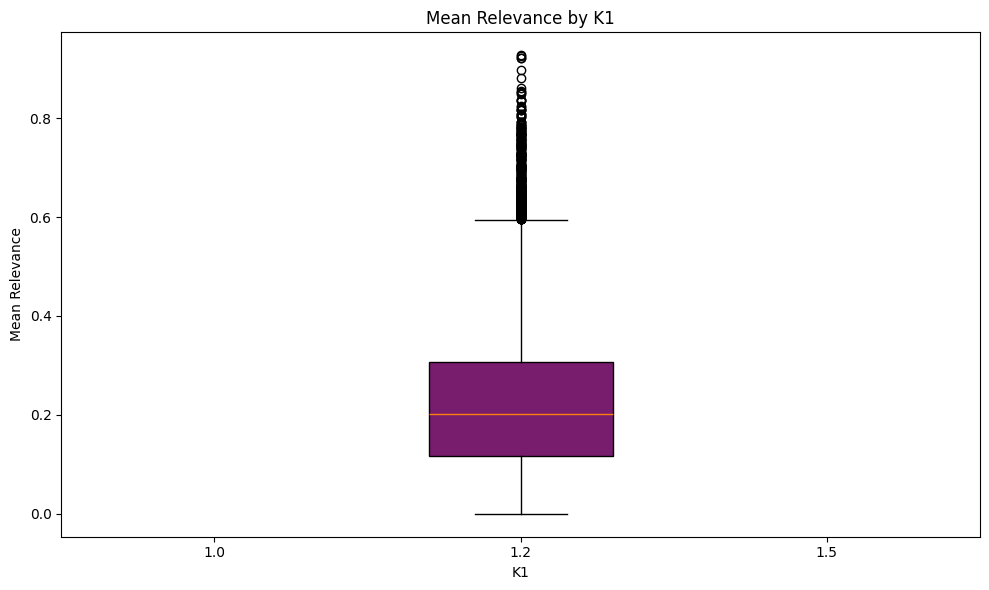

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap

# Parameters to plot
parameters = ['chunk_strategy', 'chunk_len', 'stride', 'embedder', 'c', 'k1']

# Create inferno colormap
inferno = get_cmap('inferno')

###################################
dff = df[(df.k1 == 1.2) & (df.c == 60)]
###################################

# Create a figure for each parameter
for parameter in parameters:
    # Get unique values for the parameter and sort them
    unique_values = sorted(list(set(df[parameter])))
    
    # Prepare data for boxplots
    data = [dff[dff[parameter] == val].mean_relevance for val in unique_values]
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create positions and colors
    positions = range(1, len(unique_values) + 1)
    colors = [inferno(i/len(unique_values)) for i in range(len(unique_values))]
    
    # Create boxplot
    boxplot = ax.boxplot(data, 
                        positions=positions,
                        widths=0.6,
                        patch_artist=True)
    
    # Apply colors
    for box, color in zip(boxplot['boxes'], colors):
        box.set_facecolor(color)
    
    # Customize plot
    ax.set_xticks(positions)
    
    # Handle different parameter types differently for xlabels
    if parameter in ['chunk_strategy', 'embedder']:
        # For categorical parameters, use the values directly
        ax.set_xticklabels(unique_values)
    else:
        # For numerical parameters, convert to string
        ax.set_xticklabels([str(x) for x in unique_values])
    
    ax.set_xlabel(parameter.capitalize().replace('_', ' '))
    ax.set_ylabel('Mean Relevance')
    ax.set_title(f'Mean Relevance by {parameter.capitalize().replace("_", " ")}')
    
    # Rotate xlabels if they're long
    if parameter in ['chunk_strategy', 'embedder']:
        plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

C:\Users\evgen\AppData\Local\Temp\ipykernel_1992\1061860920.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data,
C:\Users\evgen\AppData\Local\Temp\ipykernel_1992\1061860920.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data,
C:\Users\evgen\AppData\Local\Temp\ipykernel_1992\1061860920.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data,
C:\Users\evgen\AppData\Local\Temp\ipykernel_1992\1061860920.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be d

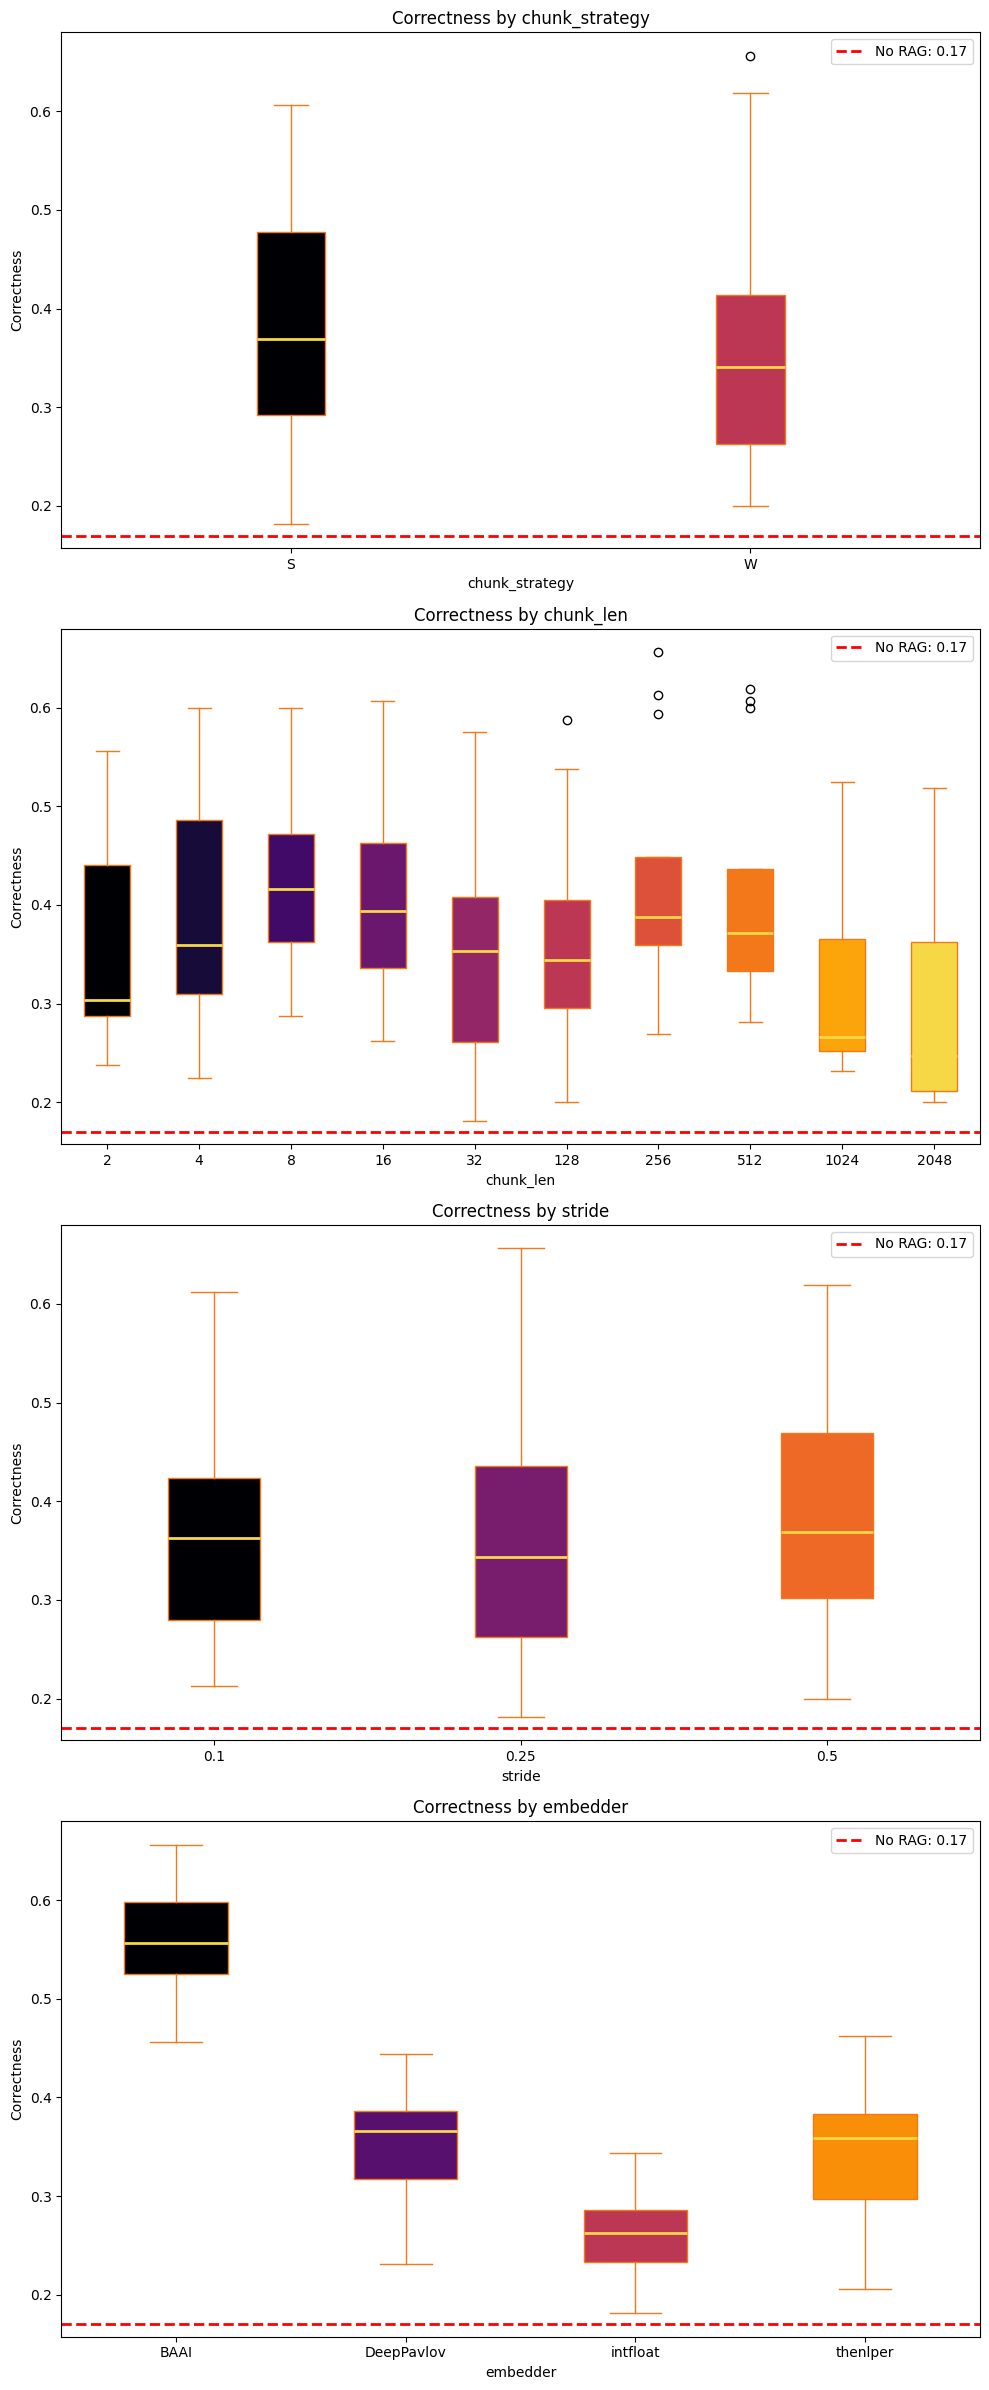

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Parameters to plot
# parameters = ['chunk_strategy', 'chunk_len', 'stride', 'embedder', 'c', 'k1']
parameters = ['chunk_strategy', 'chunk_len', 'stride', 'embedder']
ref_value = 0.17  # Set your reference value here
mean_line_color = 'red'  # Color for the reference line
inferno_cmap = plt.get_cmap('inferno')


###################################
gdff = gdf[(gdf.k1 == 1.2) & (gdf.c == 60)]
###################################

# Create a figure with subplots
fig, axes = plt.subplots(nrows=len(parameters), ncols=1, figsize=(10, 6*len(parameters)))
if len(parameters) == 1:
    axes = [axes]  # Ensure axes is always a list for consistent handling

# Plot each parameter
for ax, parameter in zip(axes, parameters):
    # Get unique values and sort them
    unique_values = sorted(list(set(gdf[parameter])))
    
    # Prepare data for boxplot - a list of arrays
    data = [gdff[gdff[parameter] == val]['correctness'].values for val in unique_values]
    
    # Create the boxplot with inferno colors
    boxprops = dict(facecolor=inferno_cmap(0.3), color=inferno_cmap(0.7))
    medianprops = dict(color=inferno_cmap(0.9), linewidth=2)
    whiskerprops = dict(color=inferno_cmap(0.7))
    capprops = dict(color=inferno_cmap(0.7))
    
    bp = ax.boxplot(data, 
                   labels=[str(val) for val in unique_values],
                   boxprops=boxprops,
                   medianprops=medianprops,
                   whiskerprops=whiskerprops,
                   capprops=capprops,
                   patch_artist=True)
    
    # Add reference line
    ax.axhline(y=ref_value, color=mean_line_color, linestyle='--', linewidth=2, 
               label=f'No RAG: {ref_value:.2f}')
    
    # Add labels and title
    ax.set_xlabel(parameter)
    ax.set_ylabel('Correctness')
    ax.set_title(f'Correctness by {parameter}')
    ax.legend()
    
    # Add color gradient to boxes
    for i, box in enumerate(bp['boxes']):
        box.set_facecolor(inferno_cmap(i/len(unique_values)))

plt.tight_layout()
plt.show()

In [62]:
t = df[(df.c==60) & (df.k1 == 1.2) 
        & (df.dataset=='bench')
        & (df.embedder == 'BAAI')
        ]
t = t.groupby(['file', 'vector_variance', 'silhouette_score_euclidian', 'silhouette_score_cosine', 'EID', 'redundancy', 'dim', 'chunk_len'])[['correctness', 'mean_relevance']].mean().reset_index()

In [67]:
t.chunk_len = t.chunk_len.apply(lambda x: sorted(list(set(t.chunk_len))).index(x))

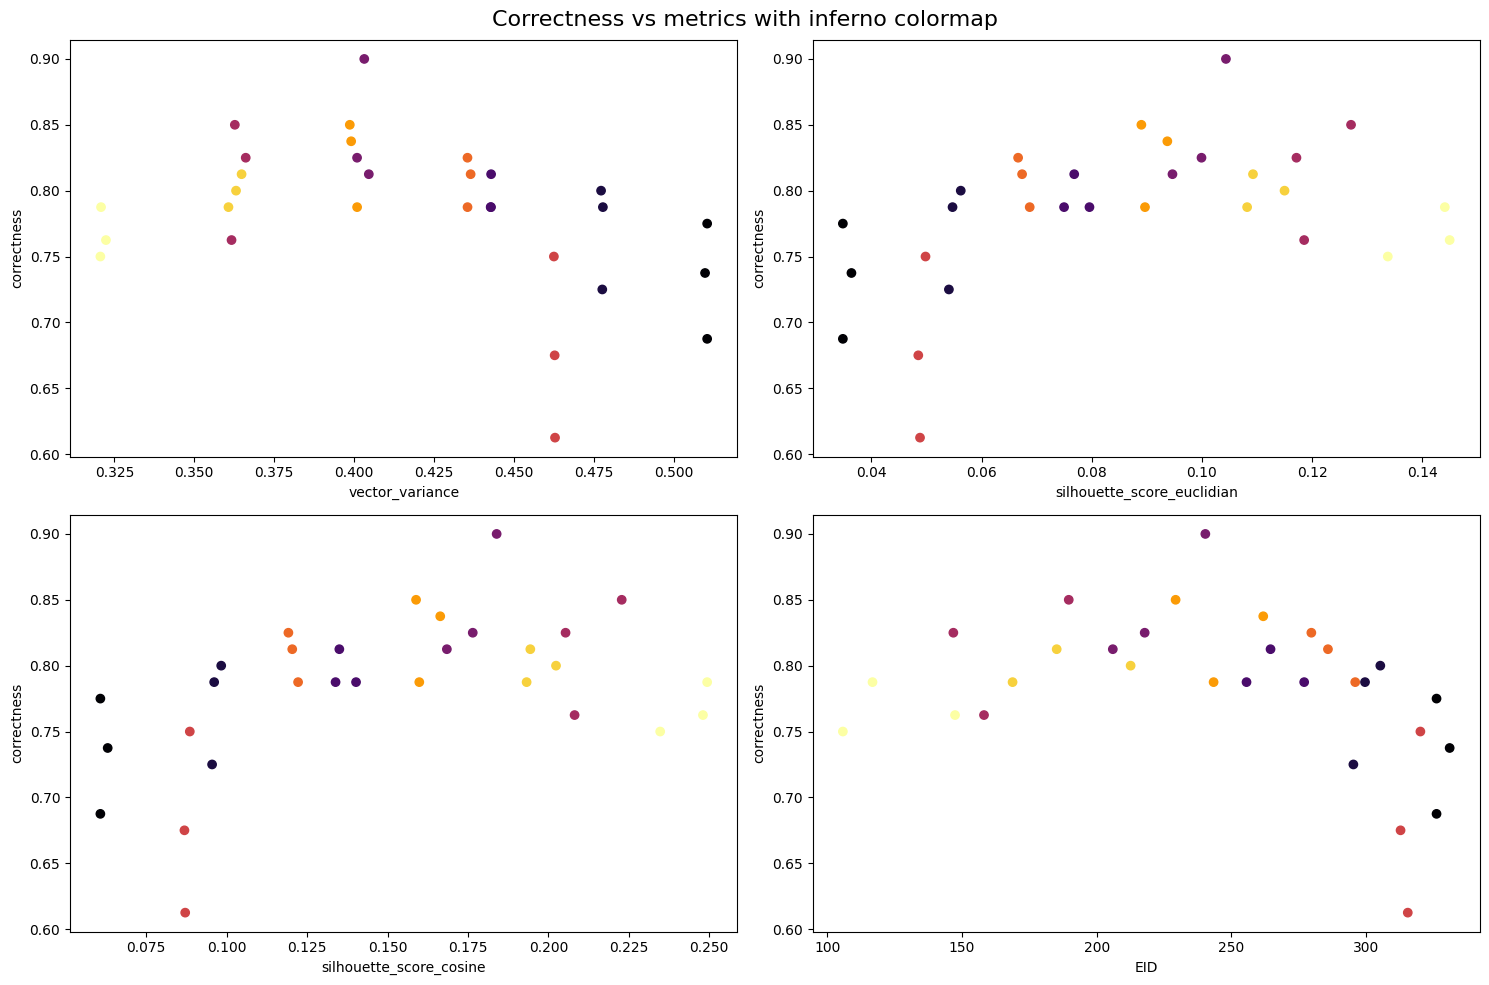

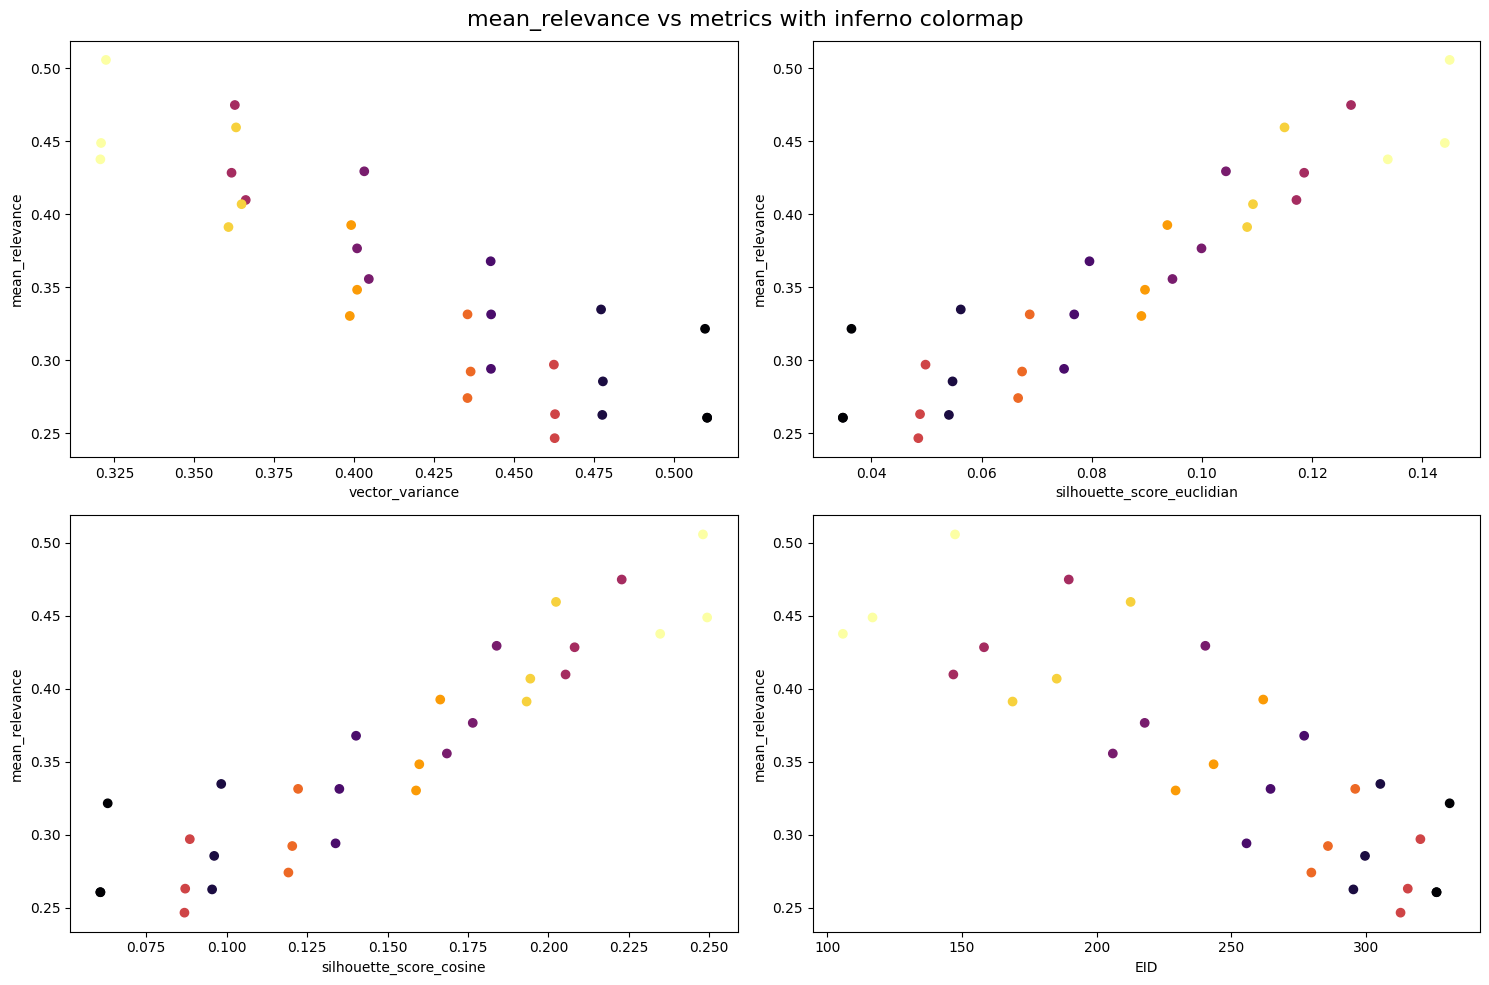

In [75]:
import matplotlib.pyplot as plt

# metrics = ['vector_variance', 'silhouette_score_euclidian', 
#            'silhouette_score_cosine', 'EID', 'redundancy', 'dim']

metrics = ['vector_variance', 'silhouette_score_euclidian', 
           'silhouette_score_cosine', 'EID']

# Создаем сетку графиков 2x3
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Correctness vs metrics with inferno colormap', fontsize=16)

for i, metric in enumerate(metrics):
    row = i // 2
    col = i % 2
    scatter = axes[row, col].scatter(t[metric], t['correctness'], c=t['chunk_len'], cmap='inferno')
    axes[row, col].set_xlabel(metric)
    axes[row, col].set_ylabel('correctness')

plt.tight_layout()
plt.show()

# Создаем сетку графиков 2x3
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('mean_relevance vs metrics with inferno colormap', fontsize=16)

for i, metric in enumerate(metrics):
    row = i // 2
    col = i % 2
    scatter = axes[row, col].scatter(t[metric], t['mean_relevance'], c=t['chunk_len'], cmap='inferno')
    axes[row, col].set_xlabel(metric)
    axes[row, col].set_ylabel('mean_relevance')
plt.tight_layout()
plt.show()